# Time series Basics : Exploring traditional TS --> 伝統的なTSの探り方

## 目次
https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts 

### imports(data and packages)

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import random as rd
from datetime import datetime

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.stattools import arma_order_select_ic # 情報量基準の計算
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [2]:
# データのインポート
sales = pd.read_csv("./data/sales_train.csv")
item_cate = pd.read_csv("./data/item_categories.csv")
item = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
# salesデータの型変換
sales.date = sales.date.apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [4]:
# 月別店舗別商品別のテーブルを作成
# [日付(min, max)、商品価格(mean)、商品販売数/日(sum)]
monthly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"])["date", "item_price", "item_cnt_day"].agg({"date":["min", "max"], "item_price":"mean", "item_cnt_day":"sum"})

monthly_sales.head(30)

/var/folders/6x/0whm9kbs4bg6p6xq6w7vsm0r0000gn/T/ipykernel_22999/3644630902.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"])["date", "item_price", "item_cnt_day"].agg({"date":["min", "max"], "item_price":"mean", "item_cnt_day":"sum"})


date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0
                       421     2013-01-07 2013-01-07      162.0          1.0
                       438     2013-01-31 2013-01-31      162.0          1.0
                       482     2013-01-09 2013-01-14     1360.0          2.0
                       484     2013-01-09 2013-01-30      124.0          4.0
                       491     2013-01-27 2013-01-27      361.0          1.0
                       498     2013-01-19 2013-01-19      124.0          1.0
                       556     2013-01-15 2013-01-25       90.0          9.0
                       642     2013-01-06 2013-01-20       90.0          6.0
                       651     2013-01-09 2013-01-25       90.0          7.0
                       657     2013-01-03 2013-01-18       90.0          2.0

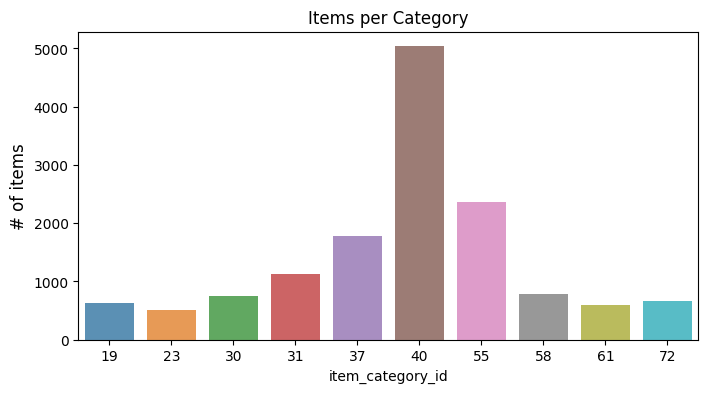

In [5]:
# アイテムカテゴリごとに品数を集計
x = item.groupby(['item_category_id']).count()
# 品数が多い順にソート
x = x.sort_values(by = 'item_id', ascending = False)
# 多いカテゴリから上位１０カテゴリを抽出。(元は84カテゴリ)
x = x.iloc[0:10].reset_index()

# 可視化
plt.figure(figsize = (8,4))
sns.barplot(data = x, x = x.item_category_id, y = x.item_id, alpha = 0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize = 12)
plt.show()

### Single series --> １変量における時系列

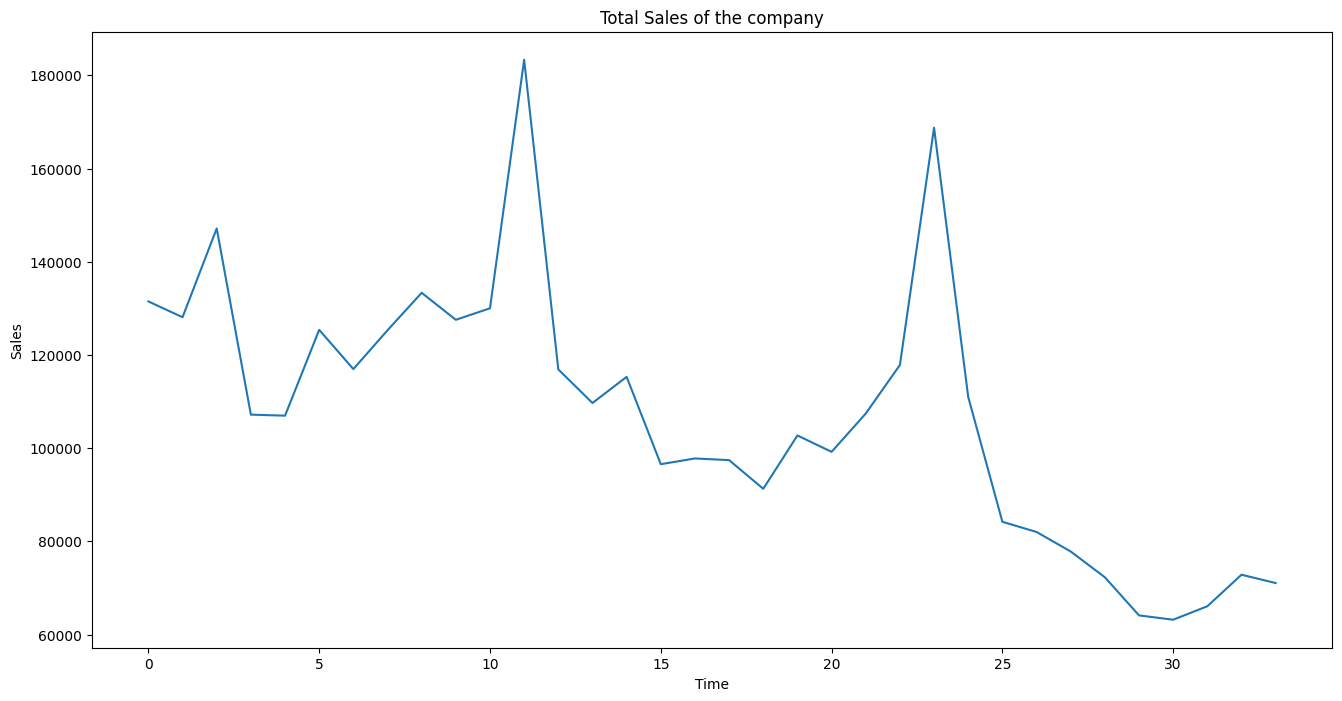

In [6]:
# 年月別のアイテム総数
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

# 可視化
plt.figure(figsize = (16, 8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

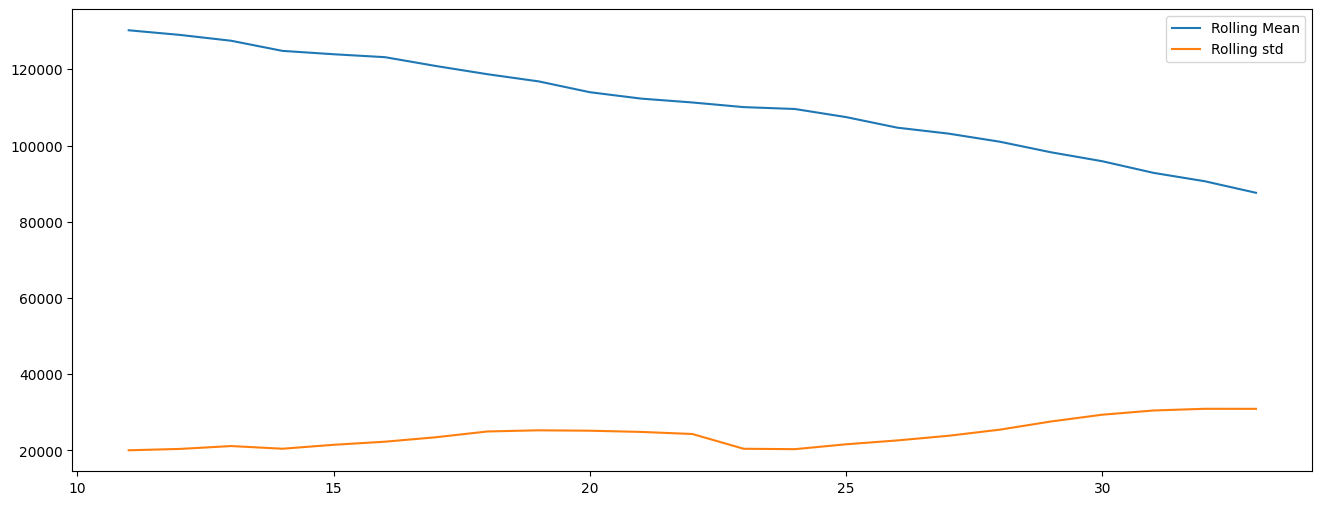

In [7]:
# 移動平均とその時の標準偏差をプロット --> 全体的に減少傾向ではあるが、日によるばらつきは大きくなっている。
plt.figure(figsize = (16, 6))
plt.plot(ts.rolling(window = 12, center = False).mean(), label = "Rolling Mean")
plt.plot(ts.rolling(window = 12, center = False).std(), label = "Rolling std")
plt.legend();

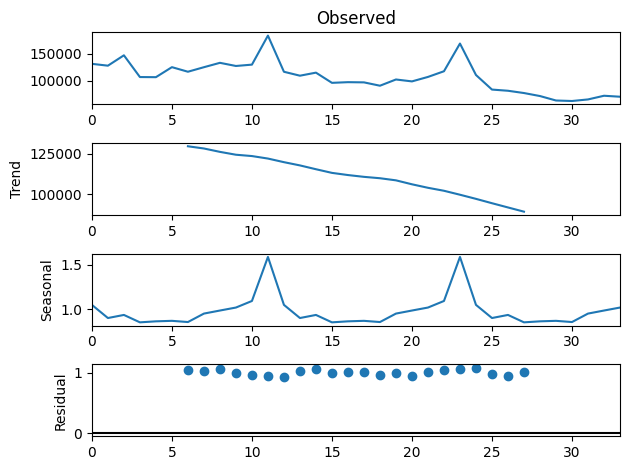

In [8]:
# 変動成分の分解
import statsmodels.api as sm

# multiplicative --> 乗法
res = sm.tsa.seasonal_decompose(ts.values, period = 12, model = "multiplicative")
res.plot()
plt.show()

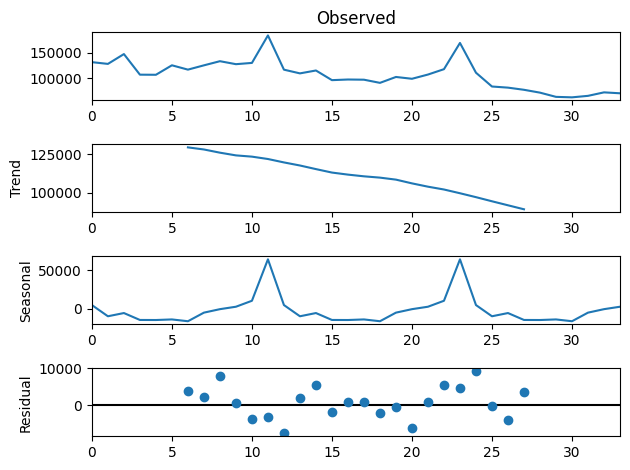

In [9]:
# additive --> 加法
res = sm.tsa.seasonal_decompose(ts.values, period = 12, model = "additive")
res.plot()
plt.show()

### Stationarity --> 定常性

##### 検定の種類
- ADF検定
- KPSS
- PP(Phillips-Perron test)

In [10]:
# ADF検定
def test_stationarity(timeseries):

    # ADF検定の実行
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')

    # 結果の格納
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    # ADF検定量における、各棄却域の表示
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [11]:
# トレンド成分を削除する --> 定常データにしていく
from pandas import Series as Series

# 階差データを作る関数
def difference(dataset, interval = 1):

    # 階差データを格納するためのリストを用意
    diff = list()
    
    # 指定した階差の数からデータセットのサイズまでのループ
    for i in range(interval, len(dataset)):
        # 階差データの作成
        value = dataset[i] - dataset[i - interval]
        # 作成した階差データを準備しておいたリストに格納
        diff.append(value)

    return Series(diff)

# invert difference forecast --> 差分予測の反転？？？ --> 使途不明関数
def inverse_difference(last_ob, value):
    return value + last_ob

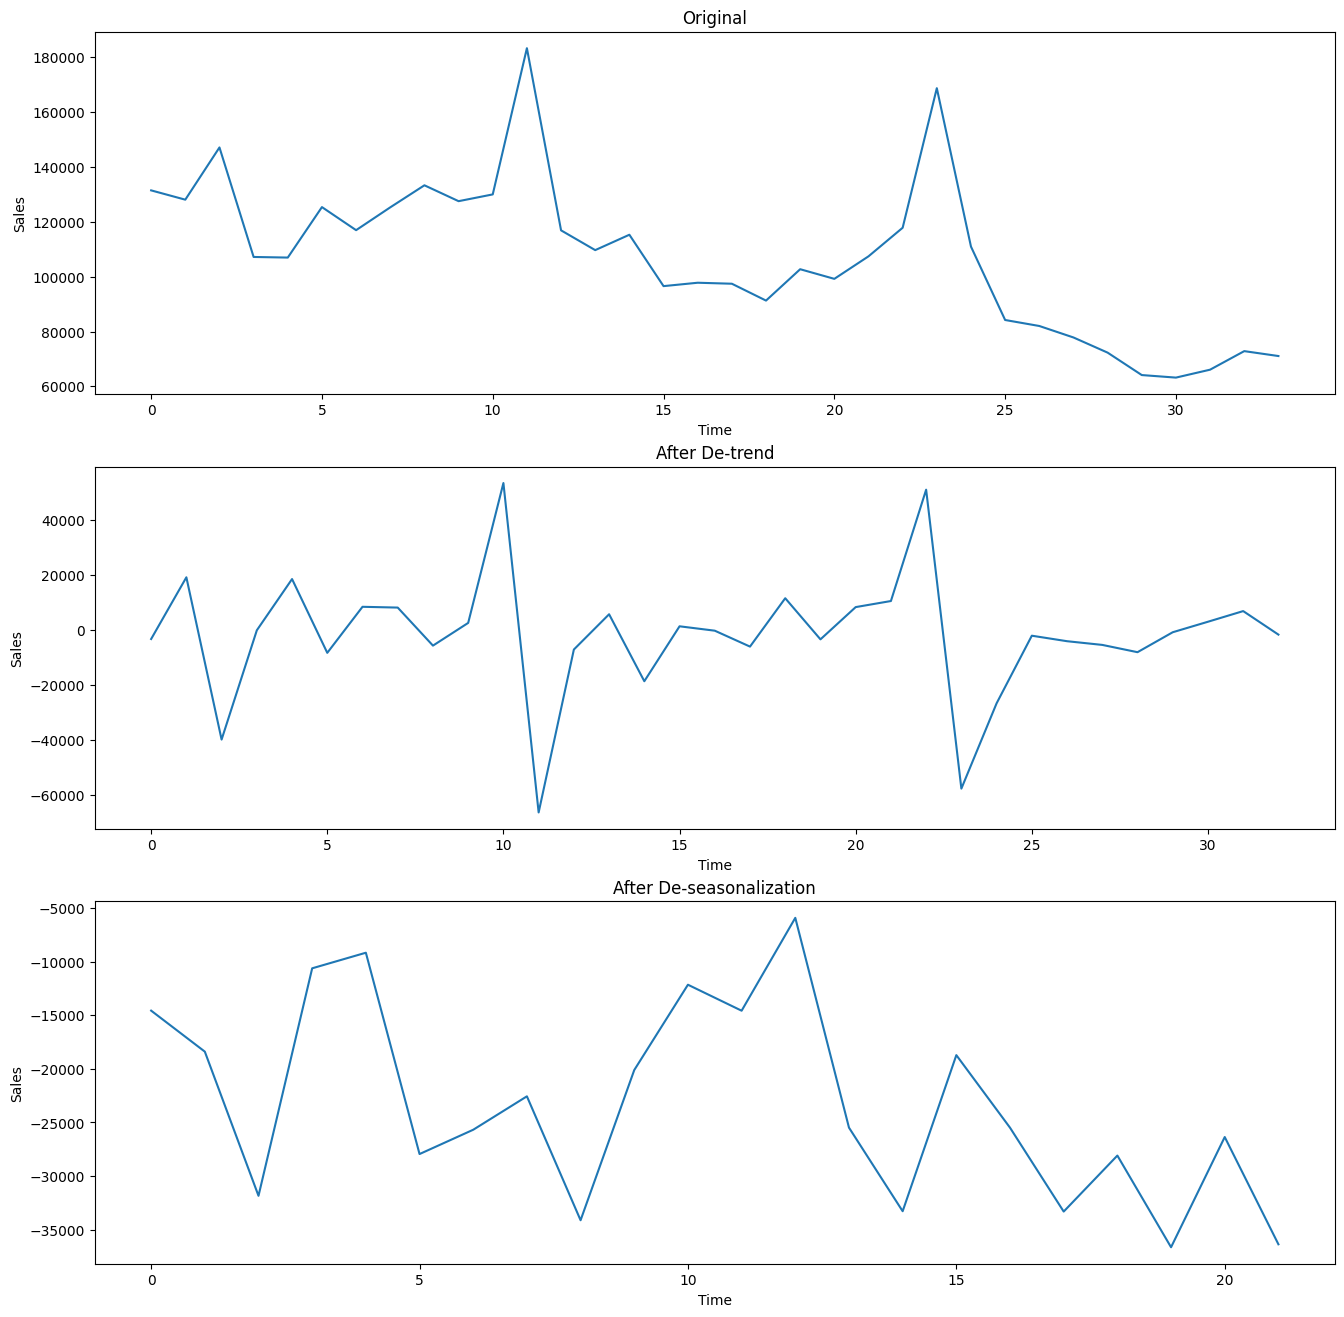

In [12]:
# それぞれの条件下で描画し、比較する。
plt.figure(figsize = (16,16))

# そのまま
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

# １回差分での描画 --> トレンド成分の除去
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts) # 関数の実行
plt.plot(new_ts)

# 季節成分も含めて除去
plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts, 12) # 関数の実行
plt.plot(new_ts)

In [13]:
# 階差データを用いて、ADF検定
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


### AR, MA, ARMA の実行

- ##### ARモデル(Autoregressive model)：自己回帰モデル
  - $AR(p)$ は$p$時点前まで遡って変数に加えたモデル
  - $c, \phi{}$は定数のパラメータ
  - $\varepsilon{_t}$はノイズ。ノイズは平均$0$で、分散が$\sigma{^2}$の確率分布から毎回独立に決定される。
$$ x_t = c + \phi{_1}{x_{t-1}} + \phi{_2}{x_{t-2}} + ... + \phi{_p}{x_{t-p}} + \varepsilon{_t} $$

In [14]:
# グラフ可視化の関数を作成する
def tsplot(y: pd.Series, 
           lags = None, 
           figsize = (10, 8), 
           style = 'bmh', 
           title = '') -> plt.show(3,2):

    # yがpandasのSeries型でなければ、起動する。
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    # 描画する際の設定を呼び出す。with文を使用するので、この関数の使用時のみ、呼び出すことになる。
    with plt.style.context(style):
        # サイズ
        fig = plt.figure(figsize = figsize)
        # 計５種類のグラフを設定
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2) # 原系列データ
        acf_ax = plt.subplot2grid(layout, (1,0)) # acfのコレログラム
        pacf_ax = plt.subplot2grid(layout, (1,1)) # pacfのコレログラム
        qq_ax = plt.subplot2grid(layout, (2,0)) # qqプロット。quantile-quantile。二つの確率分布を比較。(正規分布と〇〇) https://mathwords.net/qqplot 
        pp_ax = plt.subplot2grid(layout, (2,1)) # ppプロット。累積確率値をプロットし、2つの分布の類似度を比較。

        y.plot(ax = ts_ax)
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax, alpha = 0.5)

        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax, alpha = 0.5)

        sm.qqplot(y, line = "s", ax = qq_ax)
        qq_ax.set_title("QQ Plot")
        
        scs.probplot(y, sparams = (y.mean(), y.std()), plot = pp_ax)

        plt.tight_layout()

    return

/Users/udai/miniforge3/envs/tf/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


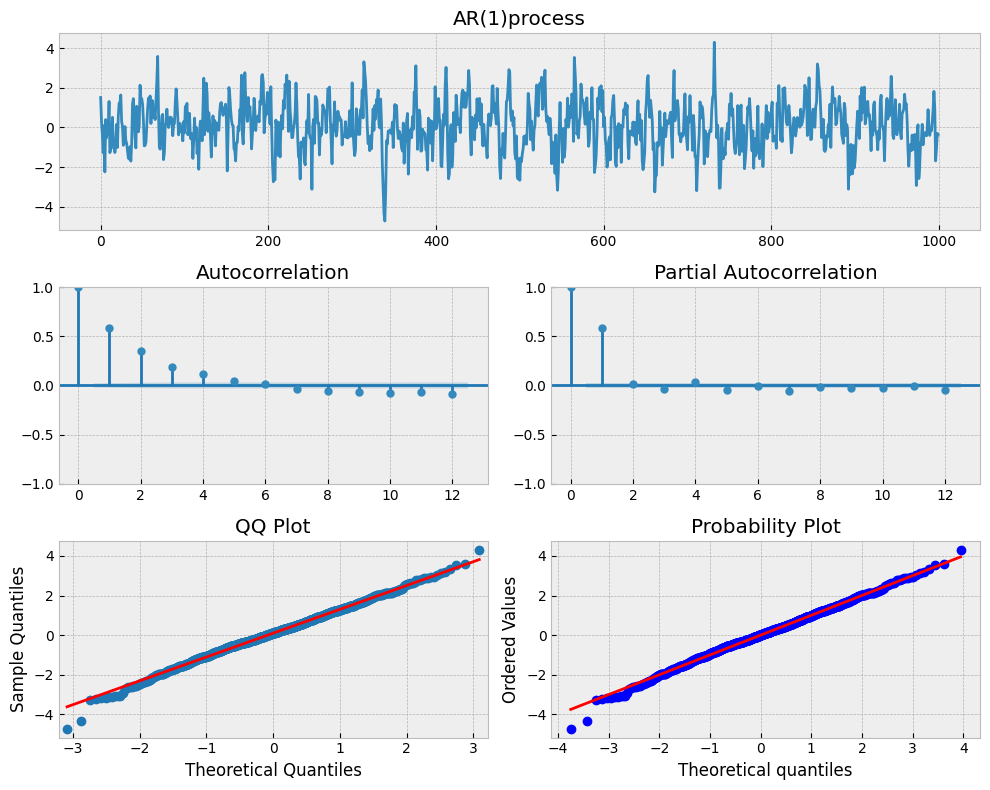

In [15]:
# AR(1)
np.random.seed(1)
n_samples = int(1000)
c = 0.6
x = ep = np.random.normal(size = n_samples)

# データ数分、階差を作り、ARを作成する
for t in range(n_samples):
    x[t] = c*x[t-1] + ep[t]

# ラグの指定
limit = 12
_ = tsplot(x, lags = limit, title = "AR(1)process")

/Users/udai/miniforge3/envs/tf/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


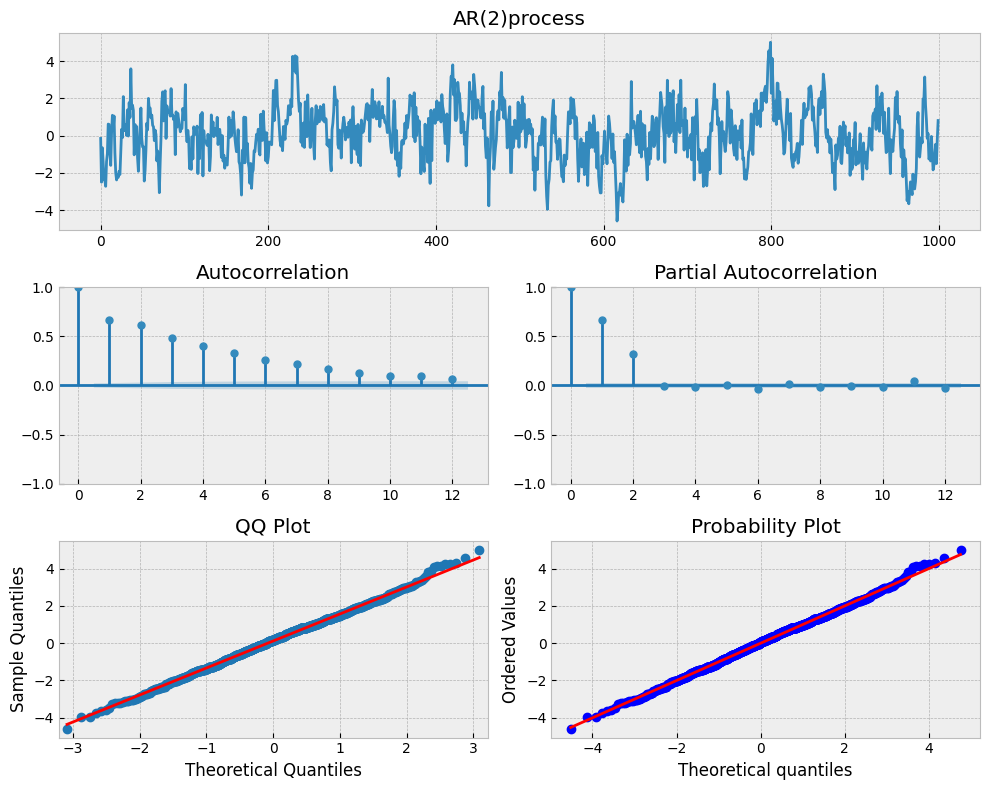

In [16]:
# AR(2)
n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# arモデル、maモデル
ar = np.r_[1, -alphas] # 横にくっつける
ma = np.r_[1, betas] # 無意味。あとで使う

# 
ar2 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n)
_ = tsplot(ar2, lags = 12, title = "AR(2)process")

- ##### ARMA
  - ある時点でのノイズが$q$時点まで影響を与える
  - $\sum_{i=1}^q{\varphi{_i}\varepsilon{_{i-1}}}$：移動平均(moving average)で、普通の線形回帰では表現できないノイズの間の関係性が表現できる。
  $$x_t = c + \sum_{i=1}^{p}{\phi{_i}x_{i-1}} + \varepsilon{_t} + \sum_{i=1}^q{\varphi{_i}\varepsilon{_{i-1}}}$$

/Users/udai/miniforge3/envs/tf/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


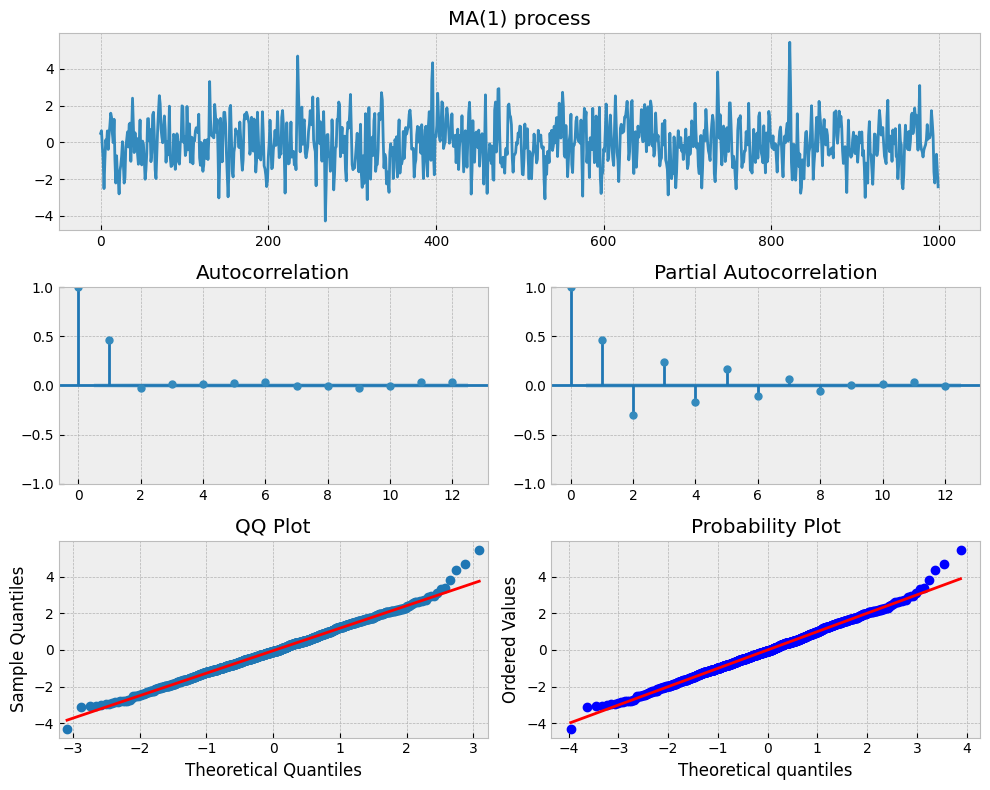

In [17]:
# MA(1)
n = int(1000)

# AR(p) alphas を０とする
alphas = np.array([0.])
betas = np.array([0.8])

# ラグ０とマイナスalphaを用意
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n)
limit = 12
_ = tsplot(ma1, lags = limit, title = "MA(1) process")

/Users/udai/miniforge3/envs/tf/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


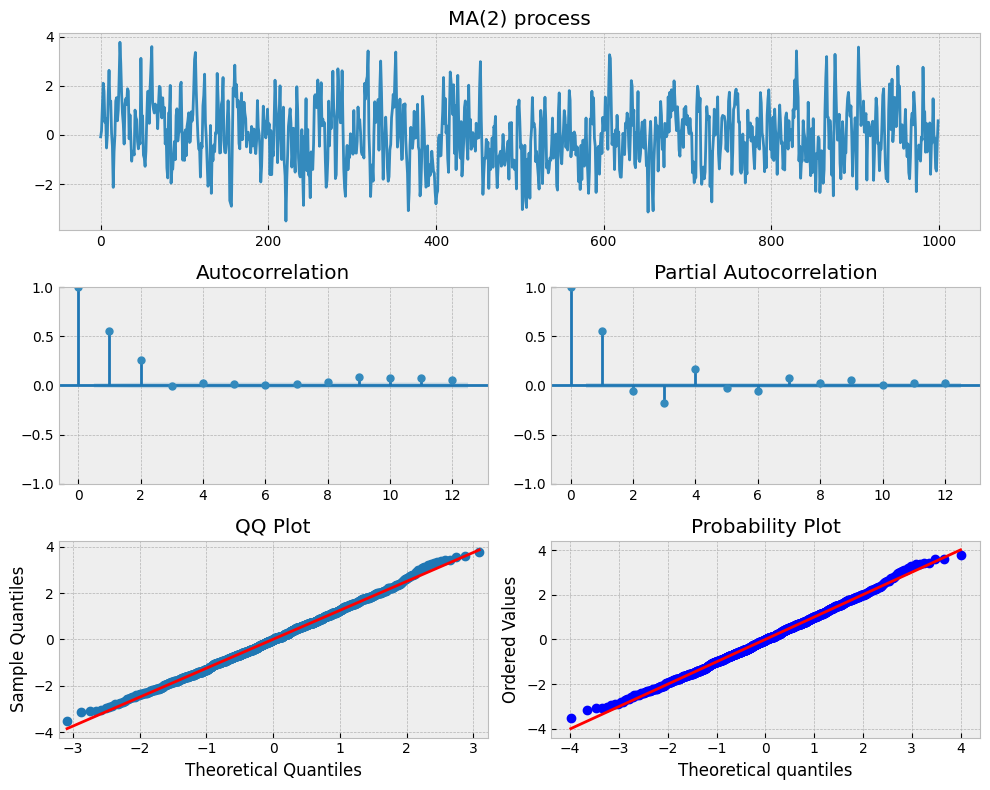

In [18]:
# MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

# データをシミュレート
ma3 = smt.arma_generate_sample(ar = ar, ma = ma, nsample = n)
_ = tsplot(ma3, lags = 12, title = "MA(2) process")

/Users/udai/miniforge3/envs/tf/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


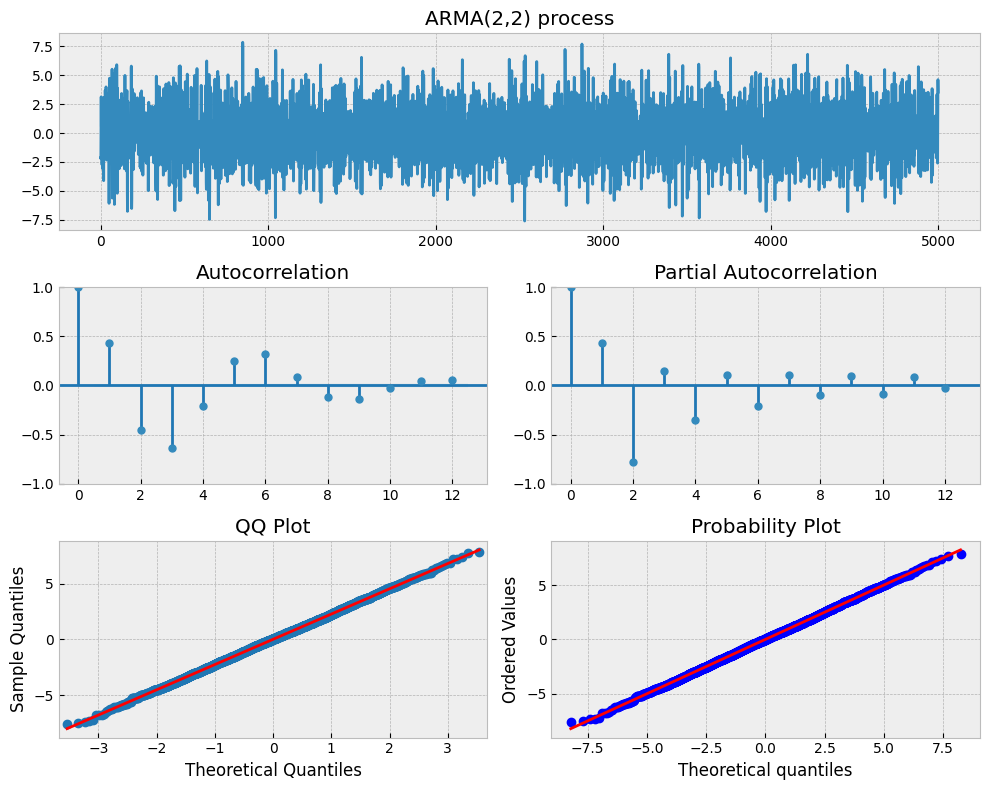

In [19]:
# ARMA(2,2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag, title="ARMA(2,2) process")

### ARとMAを使用するためのアプローチの仕方

In [20]:
# AICを基準にモデルを選ぶ
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)

for i in rng:
    for j in rng:
        try:
            # order(p,d,q)。[d:差分][p:自己回帰][q:移動平均]
            tmp_mdl = smt.ARMA(arma22, order = (i,j)).fit(method='mle', trend='nc') # モデルのパラメータを推定する
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i ,j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic:    inf | order: None
